In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import camb
from camb import model, initialpower

In [3]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.3 installed at /Users/megantabbutt/Library/Python/3.7/lib/python/site-packages/camb


In [4]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [5]:
#calculate results for these parameters
results = camb.get_results(pars)

In [6]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


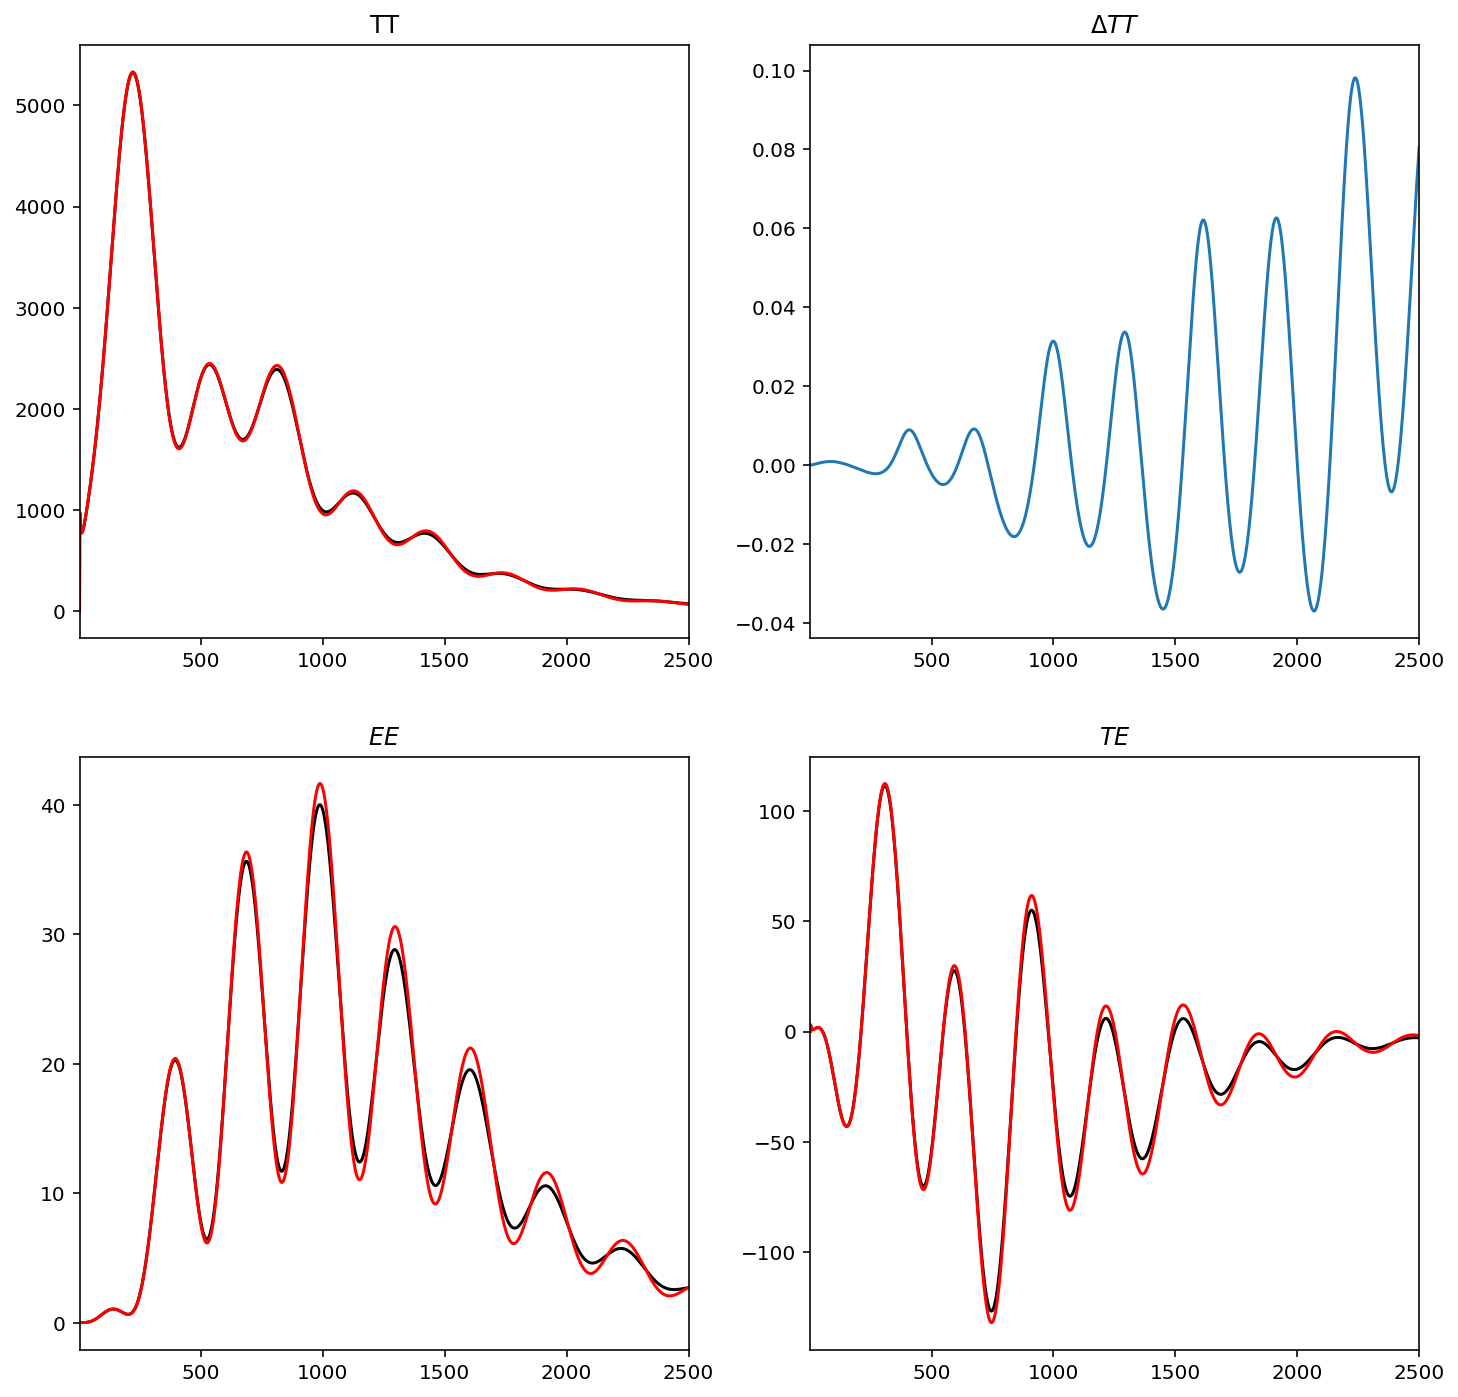

In [7]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(ls,unlensedCL[:,0], color='r')
ax[0,0].set_title('TT')
ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
ax[0,1].set_title(r'$\Delta TT$')
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='r')
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='r')
ax[1,1].set_title(r'$TE$');
for ax in ax.reshape(-1): ax.set_xlim([2,2500]);

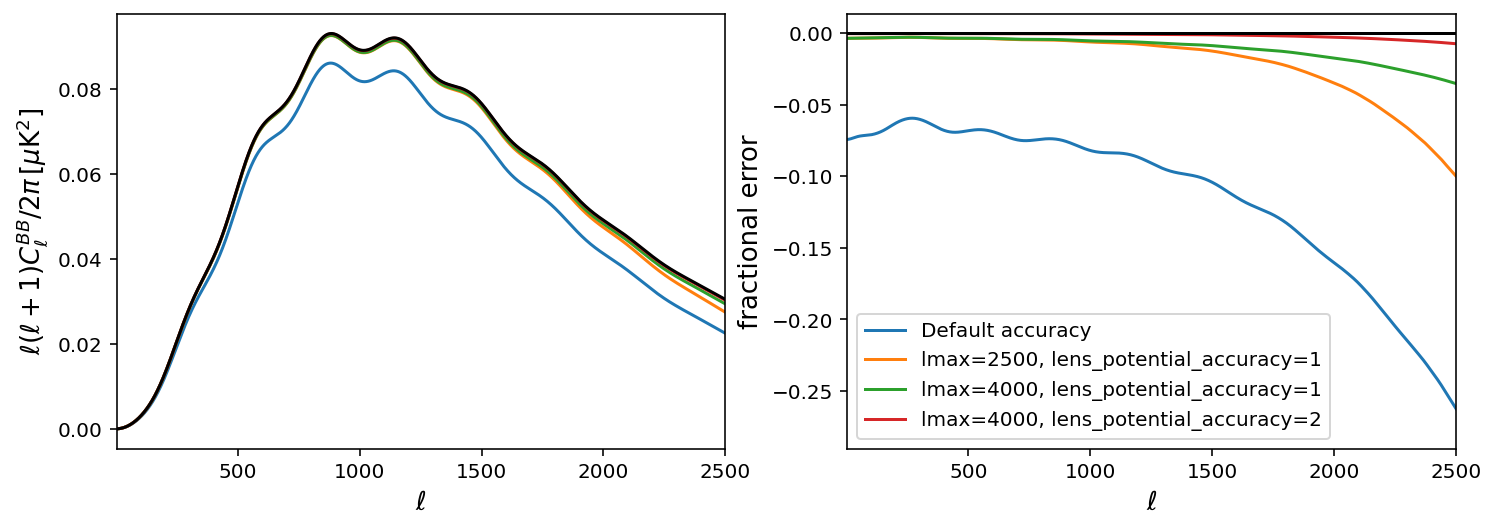

In [8]:
# The lensing B modes are non-linear, so need to be calculated carefully if you want them accurate (even at low ell)
# Need both high lmax, non-linear lensing and high k 
# lens_potential_accuracy=1 turns on the latter, and can be increased to check precision

pars.set_for_lmax(2500, lens_potential_accuracy=1)
results = camb.get_results(pars)
lmax2500CL = results.get_lensed_scalar_cls(CMB_unit='muK')
                  
pars.set_for_lmax(4000, lens_potential_accuracy=1)
results = camb.get_results(pars)
lmax4000CL = results.get_lensed_scalar_cls(CMB_unit='muK')

pars.set_for_lmax(4000, lens_potential_accuracy=2)
results = camb.get_results(pars)
accCL = results.get_lensed_scalar_cls(CMB_unit='muK')

pars.set_for_lmax(6000, lens_potential_accuracy=4)
results = camb.get_results(pars)
refCL = results.get_lensed_scalar_cls(CMB_unit='muK')

fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(ls,totCL[:len(ls),2], color='C0')
ax[0].plot(ls,lmax2500CL[:len(ls),2], color='C1')
ax[0].plot(ls,lmax4000CL[:len(ls),2], color='C2')
ax[0].plot(ls,accCL[:len(ls),2], color='C3')
ax[0].plot(ls,refCL[:len(ls),2], color='k')

ax[0].set_xlim([2,2500])
ax[0].set_xlabel(r'$\ell$',fontsize=13)
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=13)

ax[1].plot(ls[2:],totCL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C0')
ax[1].plot(ls[2:],lmax2500CL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C1')
ax[1].plot(ls[2:],lmax4000CL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C2')
ax[1].plot(ls[2:],accCL[2:len(ls),2]/refCL[2:len(ls),2]-1, color='C3')

ax[1].axhline(0,color='k')
ax[1].set_xlim([2,2500])
ax[1].set_xlabel(r'$\ell$',fontsize=13)
ax[1].set_ylabel('fractional error', fontsize=13);
ax[1].legend(['Default accuracy','lmax=2500, lens_potential_accuracy=1',
           'lmax=4000, lens_potential_accuracy=1','lmax=4000, lens_potential_accuracy=2']);

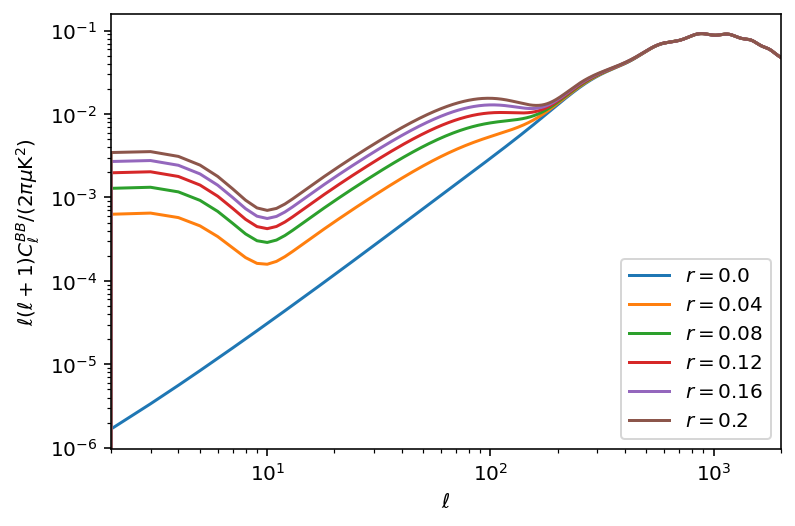

In [9]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params) #warning OK here, not changing scalars
    cl = results.get_total_cls(lmax, CMB_unit='muK')
    plt.loglog(np.arange(lmax+1),cl[:,2])
plt.xlim([2,lmax])
plt.legend(["$r = %s$"%r for r in  rs], loc='lower right');
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/ (2\pi \mu{\rm K}^2)$')
plt.xlabel(r'$\ell$');